# Barlow-Beeston experiments

In [1]:
from iminuit import Minuit
from iminuit.cost import poisson_chi2
import numpy as np
from scipy.stats import norm, truncexpon
from scipy.optimize import root_scalar, minimize
import matplotlib.pyplot as plt
from IPython.display import display

## Generate toy example

In [2]:
rng = np.random.default_rng(2)

ndata = 1000
nmc = 150
fsig = 0.25
bins = 15

b = truncexpon(1, 0, 2).rvs(size=int((1-fsig) * ndata), random_state=rng)
s = norm.rvs(1, 0.1, size=int(fsig * ndata), random_state=rng)
x = np.append(b, s)

w, xe = np.histogram(x, bins=bins, range=(0, 2))

b_mc = truncexpon(1, 0, 2).rvs(size=int(0.5 * nmc), random_state=rng)
s_mc = norm.rvs(1, 0.1, size=int(0.5 * nmc), random_state=rng)

w_mc = np.array([
    np.histogram(b_mc, bins=bins, range=(0, 2))[0],
    np.histogram(s_mc, bins=bins, range=(0, 2))[0],
])

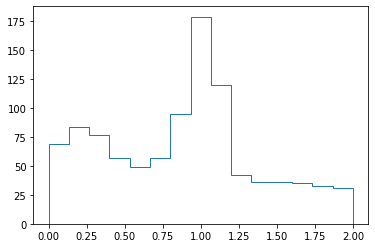

In [3]:
plt.stairs(w, xe);

## Fit without taking uncertainties of templates into account

In [4]:
def cost(yields):
    mu = 0
    for y, c in zip(yields, w_mc):
        mu += y * c / np.sum(c)
    r = poisson_chi2(w, mu)
    return r

cost.errordef = Minuit.LEAST_SQUARES

starts = np.ones(2)
m = Minuit(cost, starts)
m.limits = (0, None)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 173.9                      │              Nfcn = 119              │
│ EDM = 6.87e-07 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    667    │    27     │            │            │    0    │         │       │
│ 1 │ x1   │    333    │    20     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────┐
│    │    x0    x1 │
├────┼─────────────┤
│ x0 │   740 -72.9 │
│ x1 │ -72.9   406 │
└────┴─────────────┘

## Fit with nuisance parameter for each template entry

In [5]:
def cost(par):
    yields = par[:2]
    nuisance = par[2:]
    b = nuisance[:bins]
    s = nuisance[bins:]
    mu = 0
    for y, c in zip(yields, (b, s)):
        mu += y * c / np.sum(c)
    r = poisson_chi2(w, mu) + poisson_chi2(w_mc[0], b) + poisson_chi2(w_mc[1], s)
    return r

cost.errordef = Minuit.LEAST_SQUARES

m1 = Minuit(cost, np.ones(2 + len(w_mc[0]) * 2))
m1.limits = (0, None)
m1.migrad(ncall=100000)
m1.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.92                      │             Nfcn = 18487             │
│ EDM = 0.000118 (Goal: 0.0002)    │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    680    │    50     │            │            │    0    │         │       │
│ 1 │ x1   │    320    │    40     │            │            │    0    │         │       │
│ 2 │ x2   │    7.7    │    1.3    │            │            │    0    │         │       │
│ 3 │ x3   │    8.9    │    1.4    │            │            │    0    │         │       │
│ 4 │ x4   │    8.1    │    1.3    │            │            │    0    │         │       │
│ 5 │ x5   │    6.0    │    1.1    │            │            │    0    │         │       │
│ 6 │ x6   │    5.3    │    1.0    │            │            │    0    │         │       │
│ 7 │ x7   │    6.3    │    1.1    │            │            │    0    │         │       │
│ 8 │ x8   │    3.5    │    1.3    │            │            │    0    │         │       │
│ 9 │ x9   │    1.8    │    1.2    │            │            │    0    │         │       │
│ 10│ x10  │    3.8    │    2.7    │            │            │    0    │         │       │
│ 11│ x11  │    4.9    │    0.9    │            │            │    0    │         │       │
│ 12│ x12  │    4.1    │    0.8    │            │            │    0    │         │       │
│ 13│ x13  │    3.8    │    0.8    │            │            │    0    │         │       │
│ 14│ x14  │    3.8    │    0.8    │            │            │    0    │         │       │
│ 15│ x15  │    3.7    │    0.7    │            │            │    0    │         │       │
│ 16│ x16  │    3.5    │    0.7    │            │            │    0    │         │       │
│ 17│ x17  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 18│ x18  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 19│ x19  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 20│ x20  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 21│ x21  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 22│ x22  │    0.8    │    0.7    │            │            │    0    │         │       │
│ 23│ x23  │   16.0    │    3.1    │            │            │    0    │         │       │
│ 24│ x24  │    39     │     6     │            │            │    0    │         │       │
│ 25│ x25  │    18     │     5     │            │            │    0    │         │       │
│ 26│ x26  │    0.7    │    0.6    │            │            │    0    │         │       │
│ 27│ x27  │    0.0    │    0.4    │            │            │    0    │         │       │
│ 28│ x28  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 29│ x29  │    0.0    │    0.5    │            │            │    0    │         │       │
│ 30│ x30  │    0.0    │    0.4    │            │            │    0    │         │   

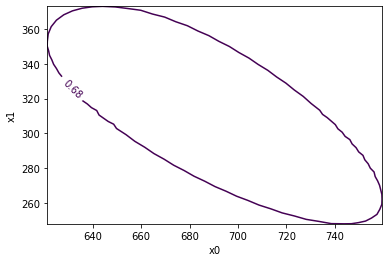

In [6]:
m1.draw_mncontour("x0", "x1");

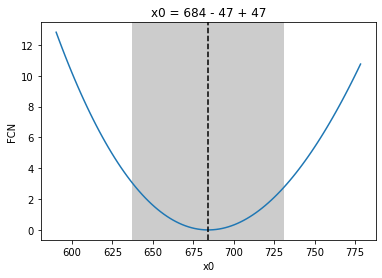

In [7]:
m1.draw_profile("x0");

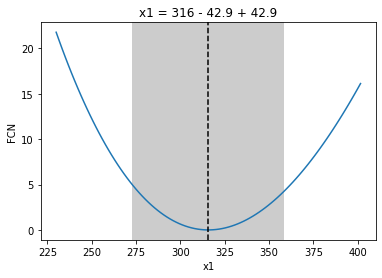

In [8]:
m1.draw_profile("x1");

## Barlow-Beeston method

This should give identical results to the method above, if implemented correctly.

In [9]:
import ROOT
import ctypes

class TFractionFitterWrapper:
    
    def __init__(self, w, w_mc):
        h_d = ROOT.TH1D("d", "", len(w), 0, 1)
        for i, wi in enumerate(w):
            h_d.SetBinContent(i+1, wi)
        h_d.SetDirectory(0)
            
        h_m = ROOT.TObjArray()
        for i, w_mc_i in enumerate(w_mc):
            h = ROOT.TH1D(f"mc{i}", "", len(w), 0, 1)
            for j, wj in enumerate(w_mc_i):
                h.SetBinContent(j+1, wj)
            h.SetDirectory(0)
            h_m.Add(h)

        self.ff = ROOT.TFractionFitter(h_d, h_m)
        self.wsum = np.sum(w)
        
    def __call__(self, *args):
        args = np.array(args, dtype=np.float64)
        args /= self.wsum
        c_double_p = ctypes.POINTER(ctypes.c_double)
        args_p = args.ctypes.data_as(c_double_p)
        return self.ff.EvaluateFCN(args_p)

    errordef = 0.5

ff = TFractionFitterWrapper(w, w_mc)

m2 = Minuit(ff, 1, 1)
m2.limits = (0, None)
m2.migrad()
m2.hesse()

Welcome to JupyROOT 6.23/01


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -3562                      │              Nfcn = 158              │
│ EDM = 3.65e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    680    │    90     │            │            │    0    │         │       │
│ 1 │ x1   │    320    │    60     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │  8.44e+03 -1.53e+03 │
│ x1 │ -1.53e+03  3.17e+03 │
└────┴─────────────────────┘

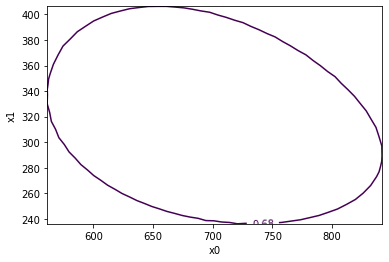

In [10]:
m2.draw_mncontour("x0", "x1");

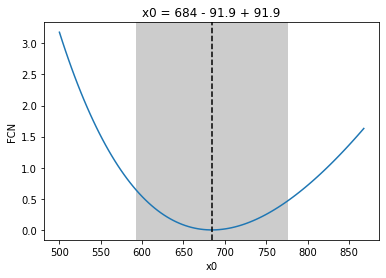

In [11]:
m2.draw_profile("x0");

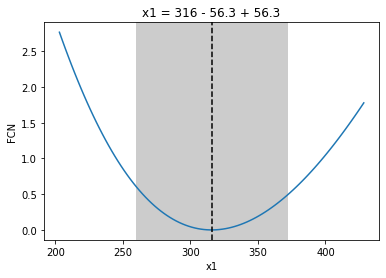

In [12]:
m2.draw_profile("x1");

In [13]:
class BarlowBeeston:
    errordef = Minuit.LEAST_SQUARES

    def __init__(self, n, m):
        self.n = n # shape (N,)
        self.m = m.astype(float) # share (K, N)
        self.M = np.sum(self.m, axis=1)

    def __call__(self, yields):
        # Barlow & Beeston, Computer Physics Communications 77 (1993) 219-228
        d = self.n # data histogram
        a = self.m # template histogram (not normalised)
        M = self.M # total number of events for each template

        p = yields / M  # p @ A = yield @ (A / M) produces expected count per bin in data histogram

        pmax = np.max(p)
        kmax = np.argmax(p)
        if np.sum(p == pmax) != 1:
            kmax = -1
        else:
            ma = np.ones_like(p, dtype=bool)
            ma[kmax] = False

        A = np.zeros(a.shape)
        for i, di in enumerate(d):
            if di == 0:
                t = 1
            else:
                # check for special case MC bin contents == 0 as described in the paper
                if kmax >= 0 and a[kmax, i] == 0:
                    A[kmax, i] = di / (1 + pmax) - p[ma] @ (a[ma, i] / (pmax - p[ma]))
                    if A[kmax,i] > 0:
                        t = -1 / pmax
                        A[ma, i] = a[ma, i] / (1 + p[ma] * t)
                        continue

                # solve eq. 15
                with np.errstate(invalid="ignore", divide="ignore"):
                    sol = root_scalar(lambda t: p @ (a[:, i] / (1 + p * t)) - di / (1 - t),
                                    #   fprime = lambda t: -p @ (a[:, i] / (1 + p * t) ** 2 * p) - di / (1 - t) ** 2,
                                    x0=0, bracket=(-1/pmax, 1))
                assert sol.converged
                t = sol.root
            A[:, i] = a[:, i] / (1 + p * t)

        npred = p @ A  # expected counts per bin
        q = poisson_chi2(d, npred)
        # print(z, npred, q)
        return q

c = BarlowBeeston(w, w_mc)

m3 = Minuit(c, m2.values[:2])
m3.throw_nan = True
m3.limits = (0, np.inf)
m3.migrad()
m3.hesse()
m3.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.241                      │              Nfcn = 138              │
│ EDM = 4.09e-05 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  0.74e3   │  0.32e3   │  -0.24e3   │   0.54e3   │    0    │         │       │
│ 1 │ x1   │  0.27e3   │  0.13e3   │  -0.27e3   │   0.18e3   │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          x0           │          x1           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.24e3  │  0.54e3   │  -0.27e3  │  0.18e3   │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   True    │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬─────────────────────┐
│    │        x0        x1 │
├────┼─────────────────────┤
│ x0 │  1.04e+05 -1.42e+04 │
│ x1 │ -1.42e+04  1.73e+04 │
└────┴─────────────────────┘

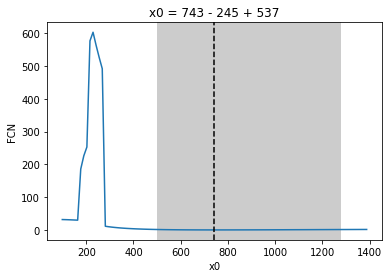

In [14]:
m3.draw_profile("x0");

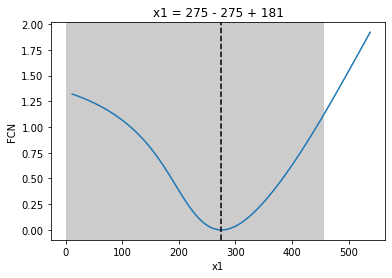

In [15]:
m3.draw_profile("x1");

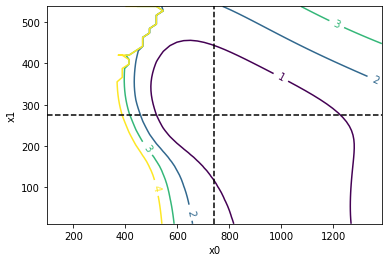

In [17]:
m3.draw_contour("x0", "x1");